In [3]:
%matplotlib notebook
import numpy as np
import torch
import matplotlib.pyplot as plt
import emlddmm
import json
import nrrd
import os

# for debugging only
import imp
imp.reload(emlddmm)

<module 'emlddmm' from '/mnt/data/csh_data/emlddmm/emlddmm.py'>

In [4]:
# todo list in this cell
# explicitly write out forward and inverse transforms instead of velocity field
# specifics for 3D to 2D mapping
# apply transforms to new data from command line
# different data types: either preprocess data and convert format, or modify code to support another data type
# reading and writing in other data types: especially nifty nii, I would rely on nibabel to do this

In [5]:
atlas_name = '/home/dtward/data/csh_data/marmoset/Woodward_2018/bma-1-mri-reorient.vtk'
label_name = '/home/dtward/data/csh_data/marmoset/Woodward_2018/bma-1-region_seg-reorient.vtk'
target_name = '/home/dtward/data/csh_data/marmoset/m1229/M1229MRI/MRI/exvivo/HR_T2/HR_T2_CM1229F-reorient.vtk'
config_file = 'config1229.json'
output_dir = '1229_test_outputs/'

In [6]:
with open(config_file) as f:
    config = json.load(f)
# I'm getting this for initial downsampling for preprocessing
downIs = config['downI']
downJs = config['downJ']

[ 39.999999  39.999999 112.000003]


<IPython.core.display.Javascript object>


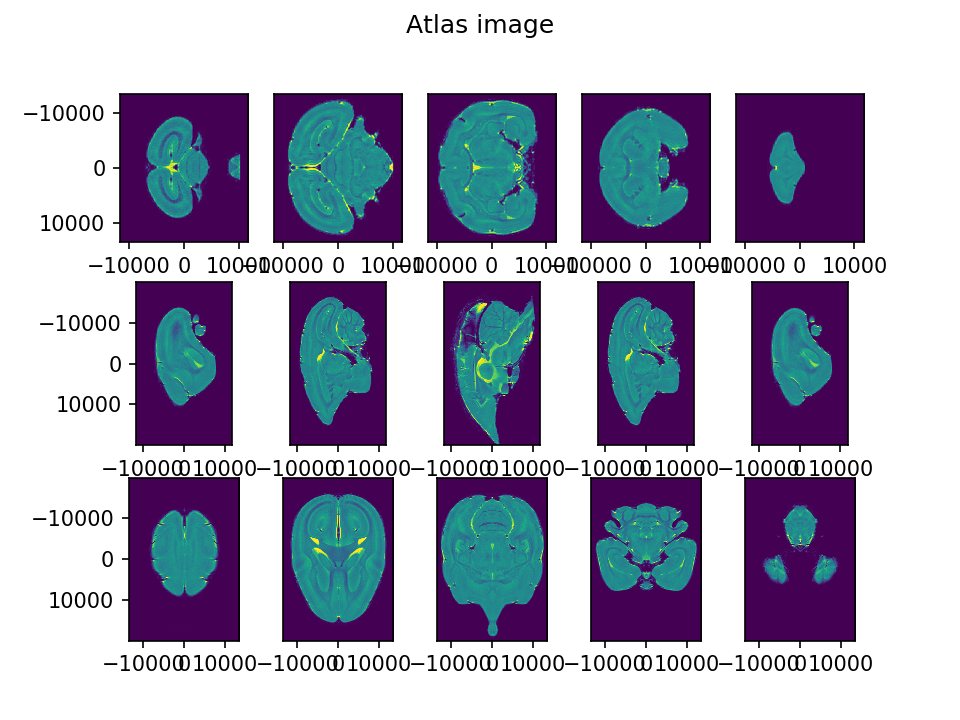

Text(0.5, 0.98, 'Atlas image')

In [7]:
# atlas
imp.reload(emlddmm)
xI,I,title,names = emlddmm.read_vtk_data(atlas_name,endian='l')
I = I.astype(float)
# normalize
I /= np.mean(np.abs(I))
dI = np.array([x[1]-x[0] for x in xI])
print(dI)
fig = emlddmm.draw(I,xI)
fig[0].suptitle('Atlas image')

In [8]:
# initial downsampling so there isn't so much on the gpu
mindownI = np.min(np.array(downIs),0)
xI,I = emlddmm.downsample_image_domain(xI,I,mindownI)
downIs = [ list((np.array(d)/mindownI).astype(int)) for d in downIs]
dI = [x[1]-x[0] for x in xI]
print(dI)
nI = np.array(I.shape,dtype=int)
# update our config variable
config['downI'] = downIs

[159.99999599999865, 159.99999600000046, 224.00000600000203]


[100.000001 100.000001 200.000003]


<IPython.core.display.Javascript object>


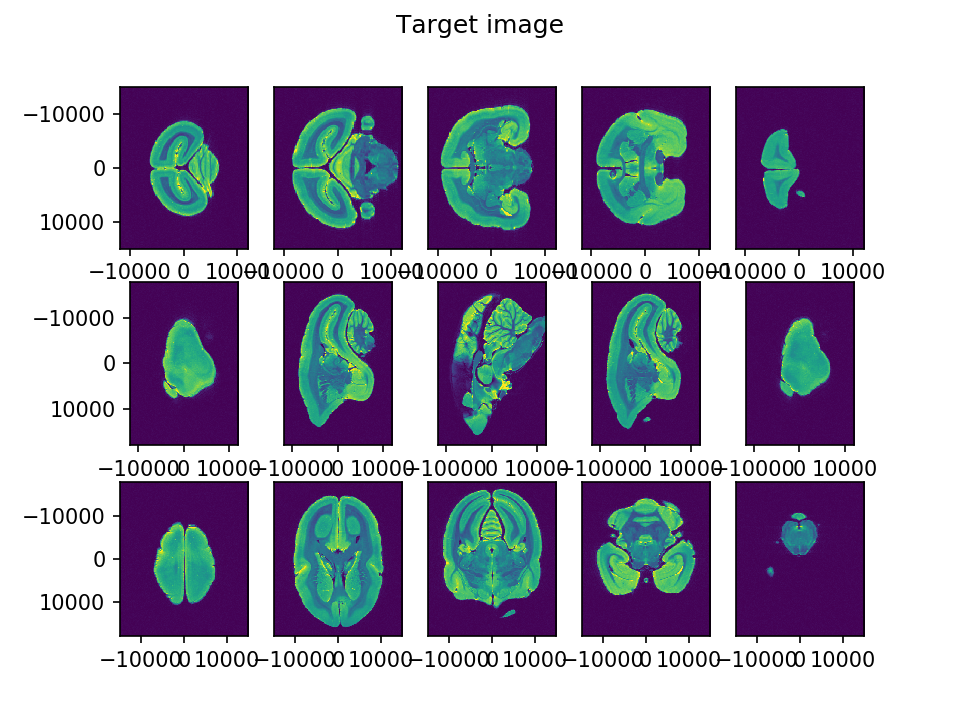

In [9]:
# target
imp.reload(emlddmm)
xJ,J,title,names = emlddmm.read_vtk_data(target_name)
J = J.astype(float)
J /= np.mean(np.abs(J))
dJ = np.array([x[1]-x[0] for x in xJ])
print(dJ)
J = J.astype(float)#**0.25
fig = emlddmm.draw(J,xJ)
fig[0].suptitle('Target image')
W0 = np.ones_like(J[0])

In [10]:
# initial downsampling so there isn't so much on the gpu
mindownJ = np.min(np.array(downJs),0)
xJ,J = emlddmm.downsample_image_domain(xJ,J,mindownJ)
W0 = emlddmm.downsample(W0,mindownJ)
downJs = [ list((np.array(d)/mindownJ).astype(int)) for d in downJs]
dJ = [x[1]-x[0] for x in xJ]
nJ = np.array(J.shape,dtype=int)
# update our config variable
config['downJ'] = downJs

<IPython.core.display.Javascript object>


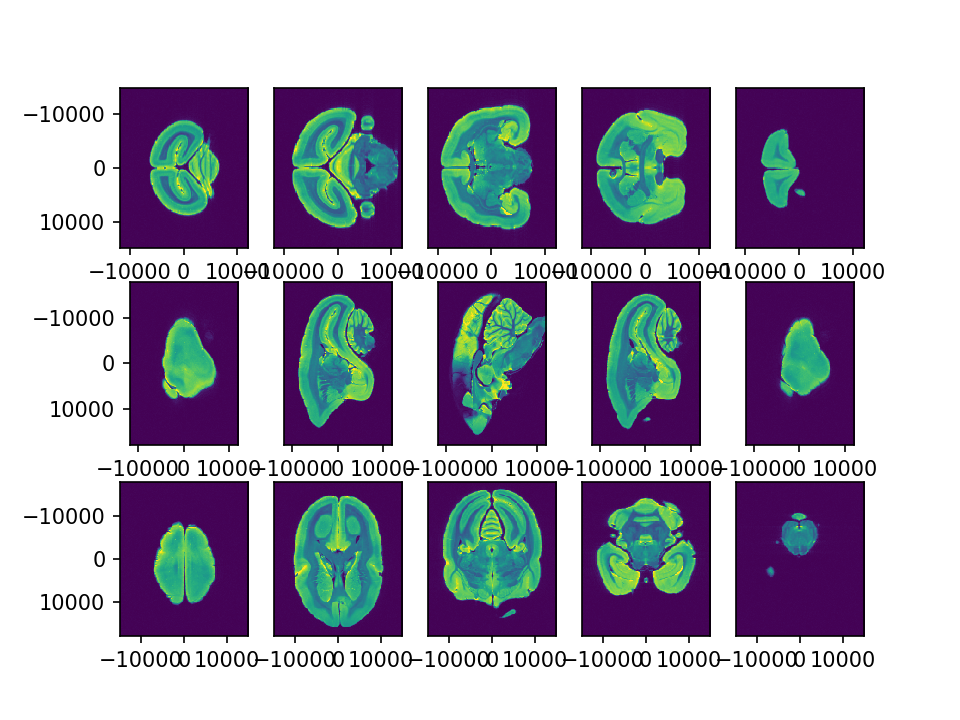

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7fe7d0c4ebd0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fe7cac889d0>]])

In [11]:
emlddmm.draw(J,xJ)

<IPython.core.display.Javascript object>


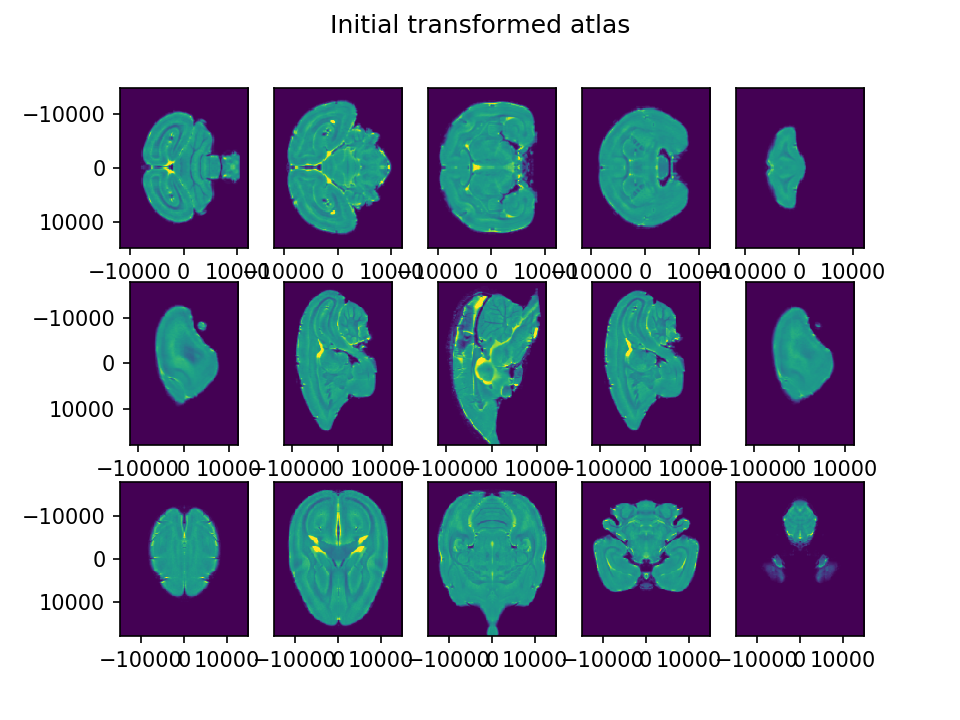

Text(0.5, 0.98, 'Initial transformed atlas')

In [12]:
imp.reload(emlddmm)
# visualize initial affine
if 'A' in config:
    A = np.array(config['A']).astype(float)
else:
    A = np.eye(4)
# this affine matrix should be 4x4, but it may be 1x4x4
if A.ndim > 2:
    A = A[0]
Ai = np.linalg.inv(A)
XJ = np.stack(np.meshgrid(*xJ,indexing='ij'),-1)
Xs = (Ai[:3,:3]@XJ[...,None])[...,0] + Ai[:3,-1]
out = emlddmm.interp(xI,I,Xs.transpose((3,0,1,2)))
fig = emlddmm.draw(out,xJ)
fig[0].suptitle('Initial transformed atlas')

Found 2 scales
dv tensor([480., 480., 672.], device='cuda:0')
a scale is 960.0


<IPython.core.display.Javascript object>


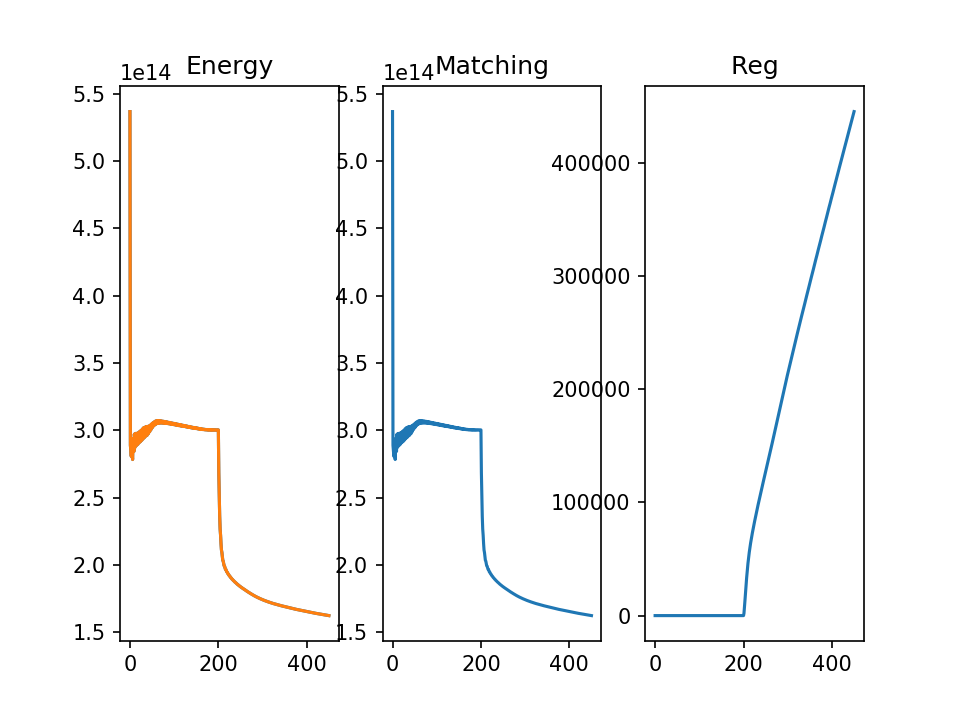

<IPython.core.display.Javascript object>


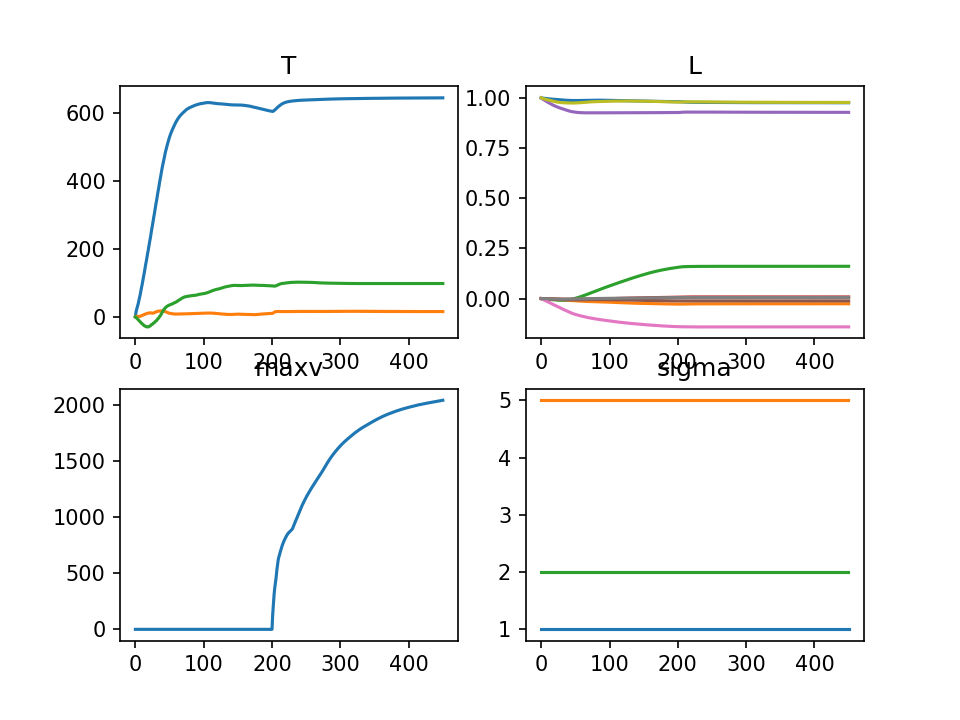

<IPython.core.display.Javascript object>


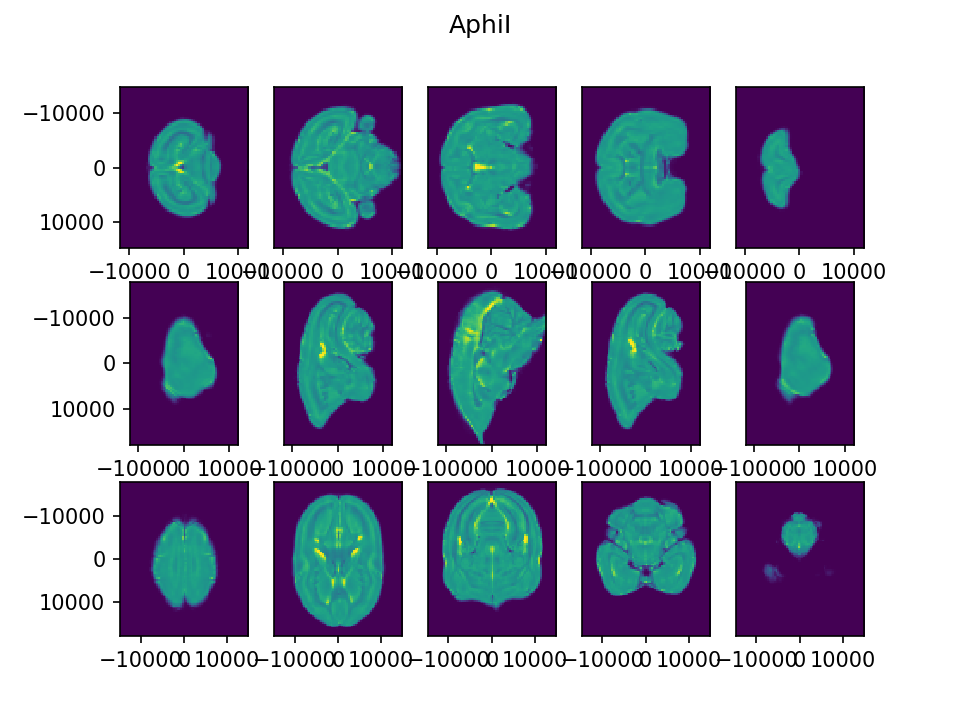

<IPython.core.display.Javascript object>


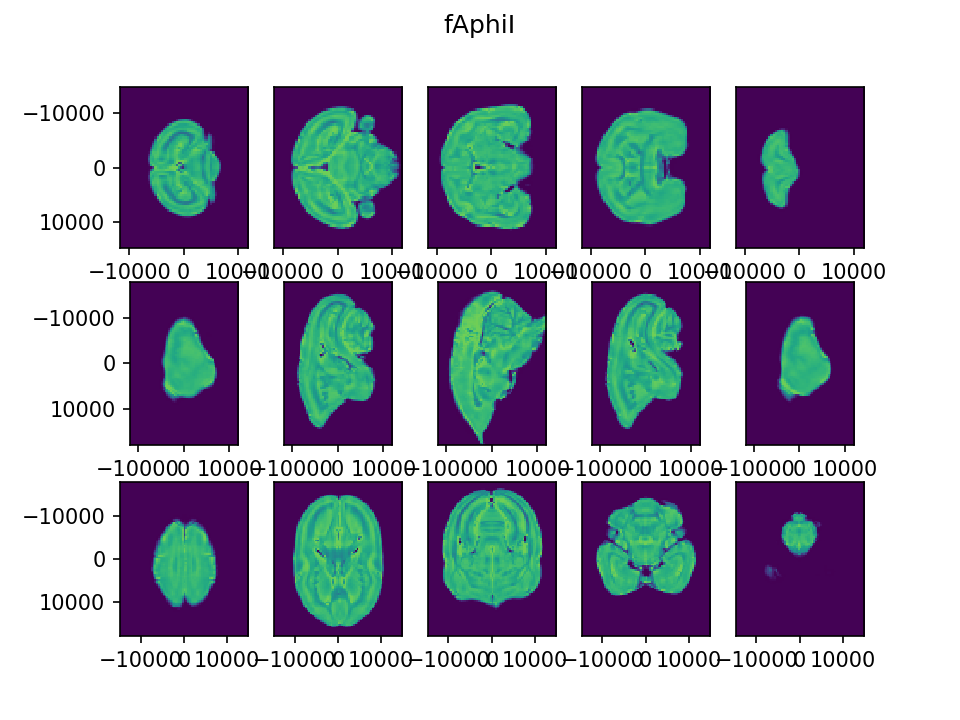

<IPython.core.display.Javascript object>


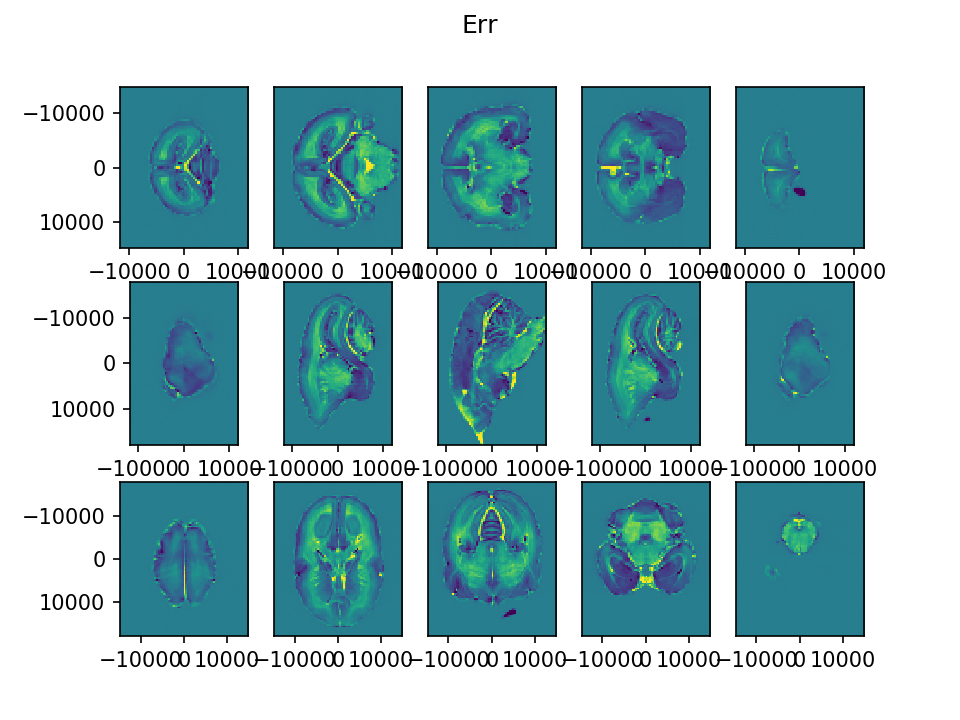

<IPython.core.display.Javascript object>


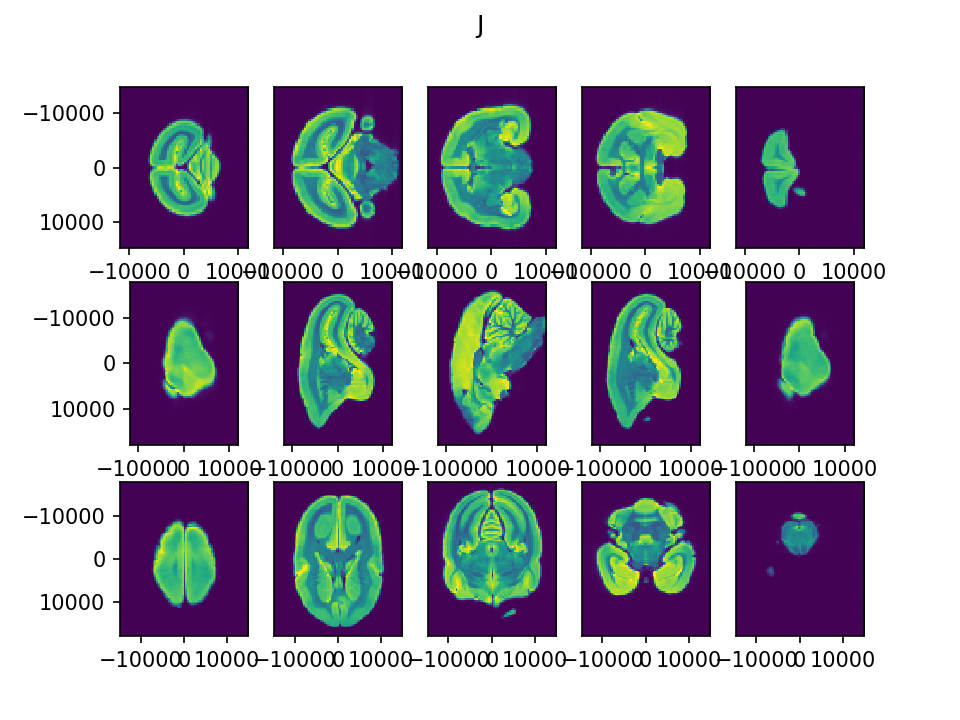

<IPython.core.display.Javascript object>


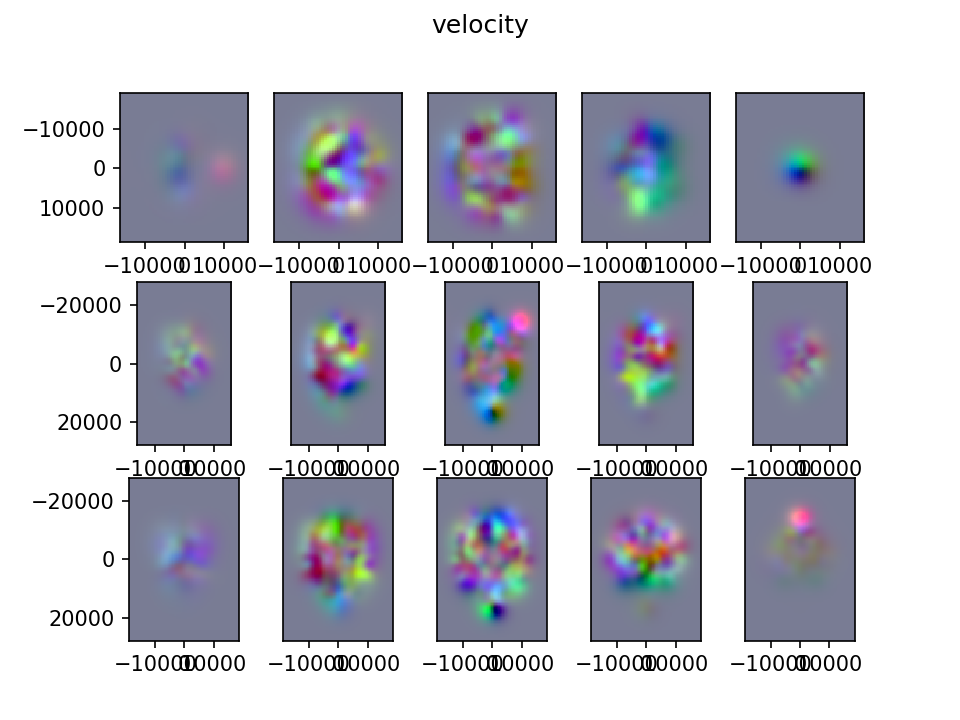

<IPython.core.display.Javascript object>


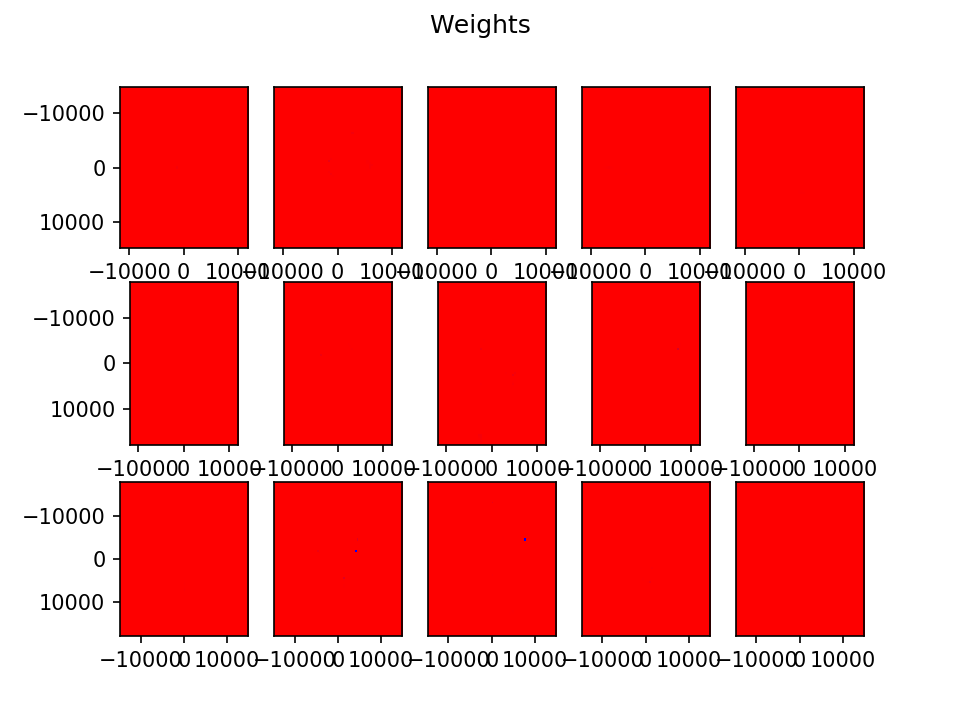

/mnt/data/csh_data/emlddmm/emlddmm.py:43: RuntimeWarning: invalid value encountered in true_divide
  J /= (vmax[:,None,None,None] - vmin[:,None,None,None])


Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190
Finished iteration 200
Iteration 210, translation oscilating, reducing eA to 9e-05
Finished iteration 210
Iteration 220, linear oscilating, reducing eA to 8.1e-05
Finished iteration 220
Iteration 230, translation oscilating, reducing eA to 7.290000000000001e-05
Finished iteration 230
Iteration 240, translation oscilating, reducing eA to 6.561000000000002e-05
Finished iteration 240
Iteration 250, translation oscilating, reducing eA to 5.904900000000002e-05
Finished iteration 250
Iteration 260, translation oscilating, reducing eA to 5.314410000000

<IPython.core.display.Javascript object>


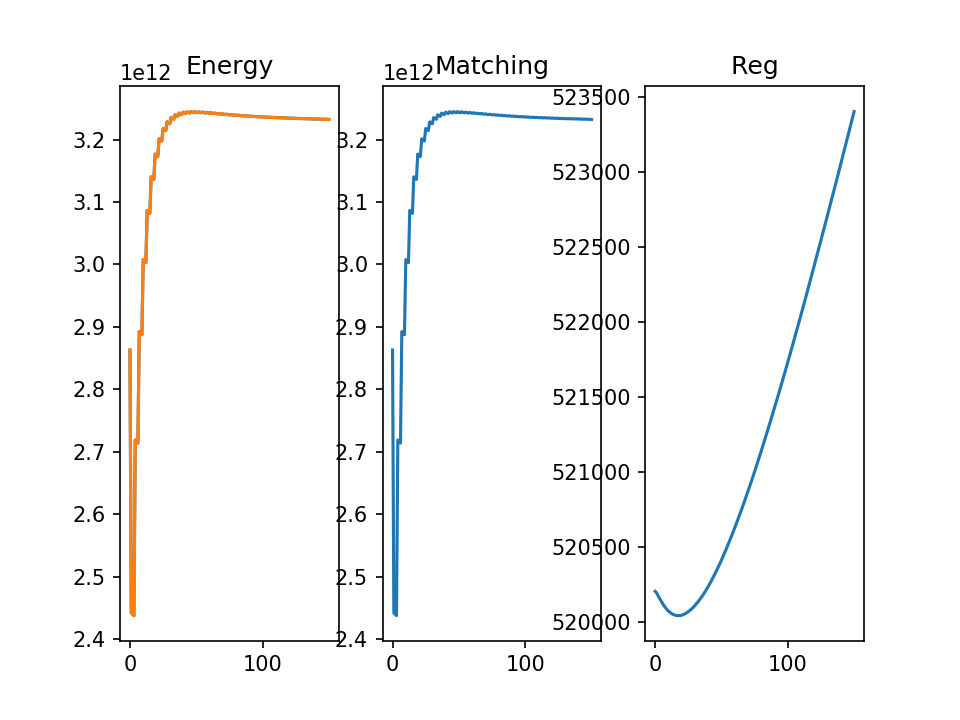

<IPython.core.display.Javascript object>


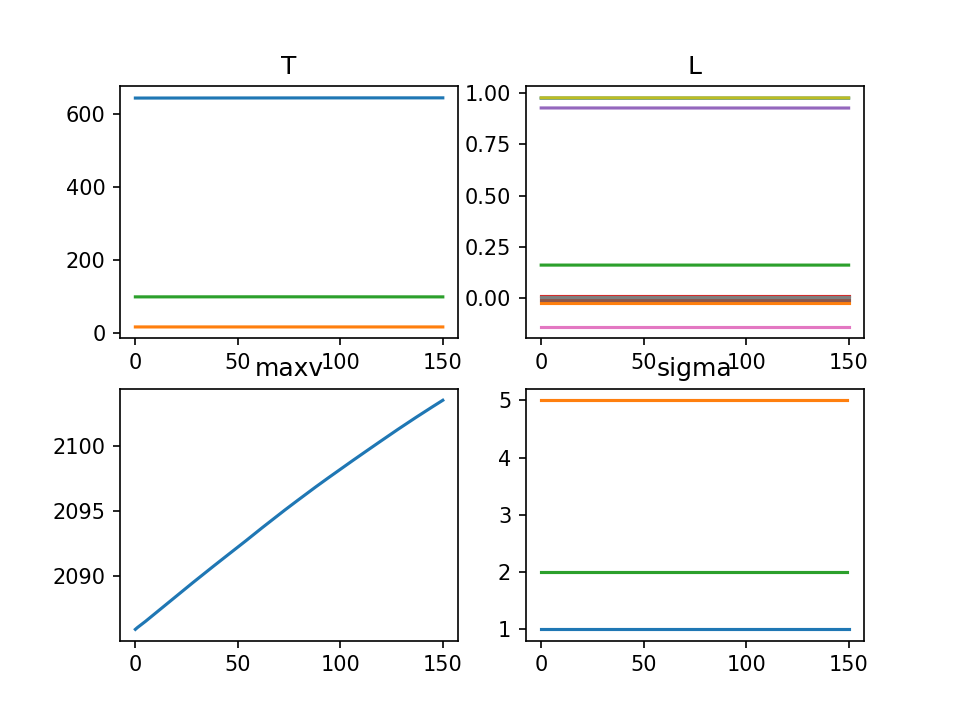

<IPython.core.display.Javascript object>


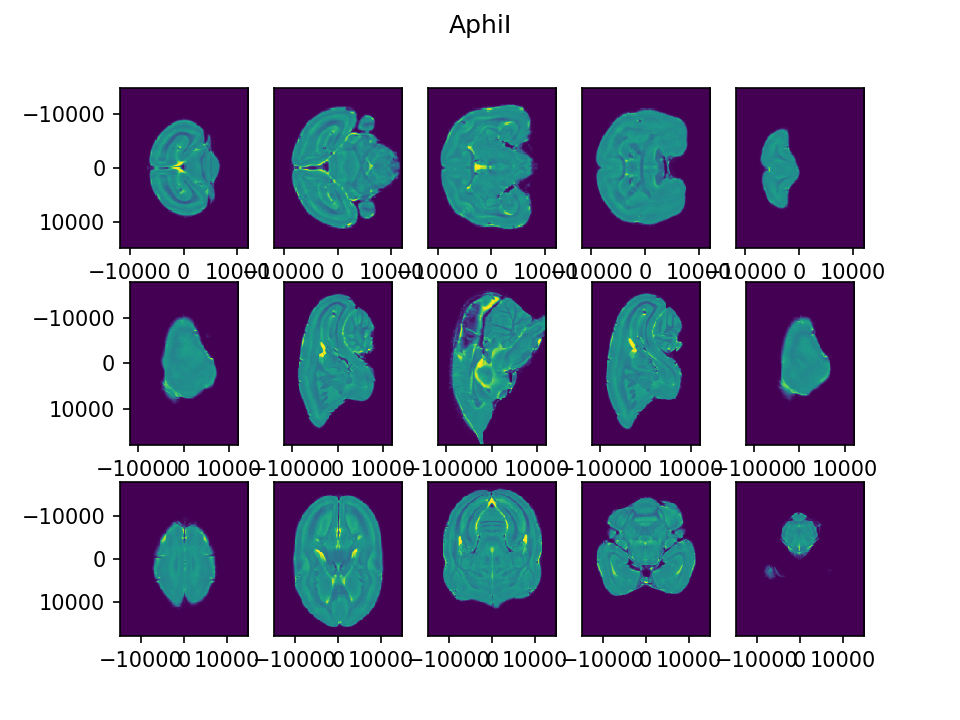

<IPython.core.display.Javascript object>


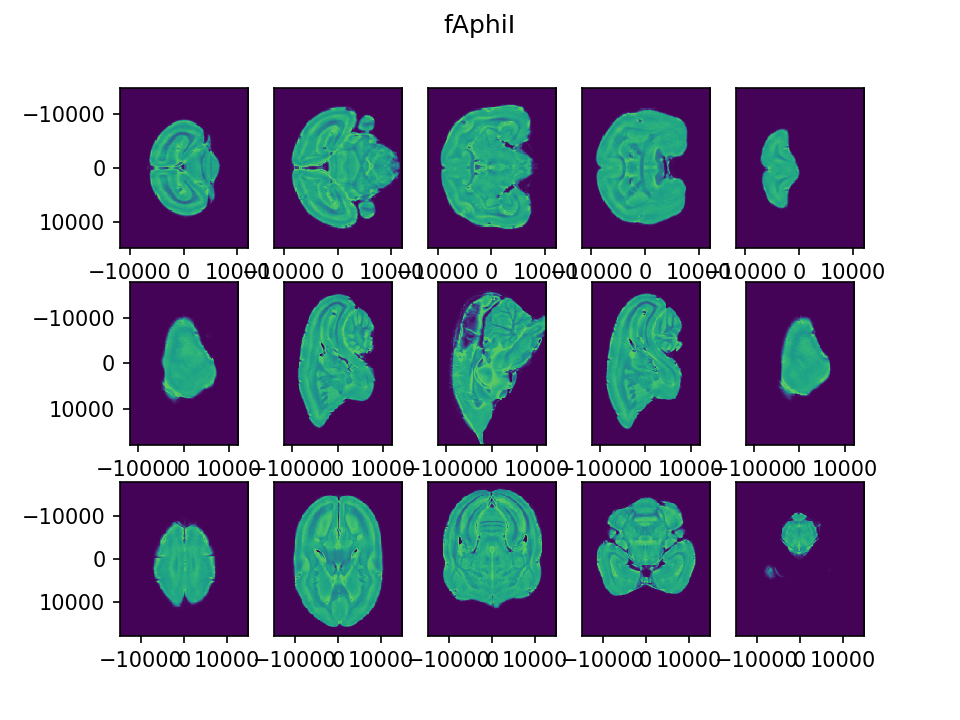

<IPython.core.display.Javascript object>


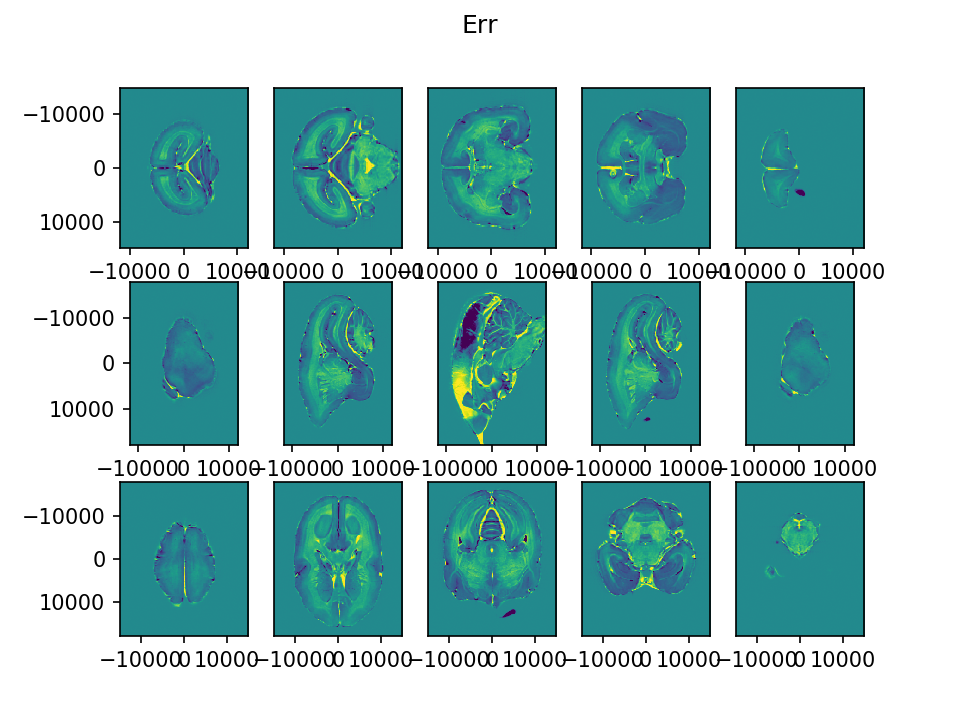

<IPython.core.display.Javascript object>


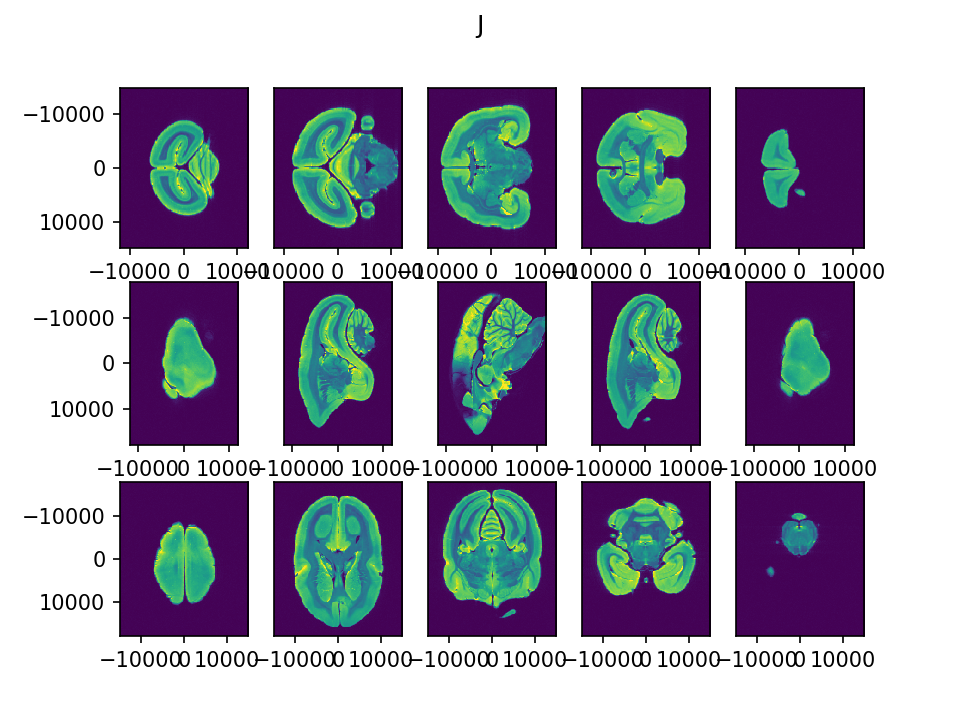

<IPython.core.display.Javascript object>


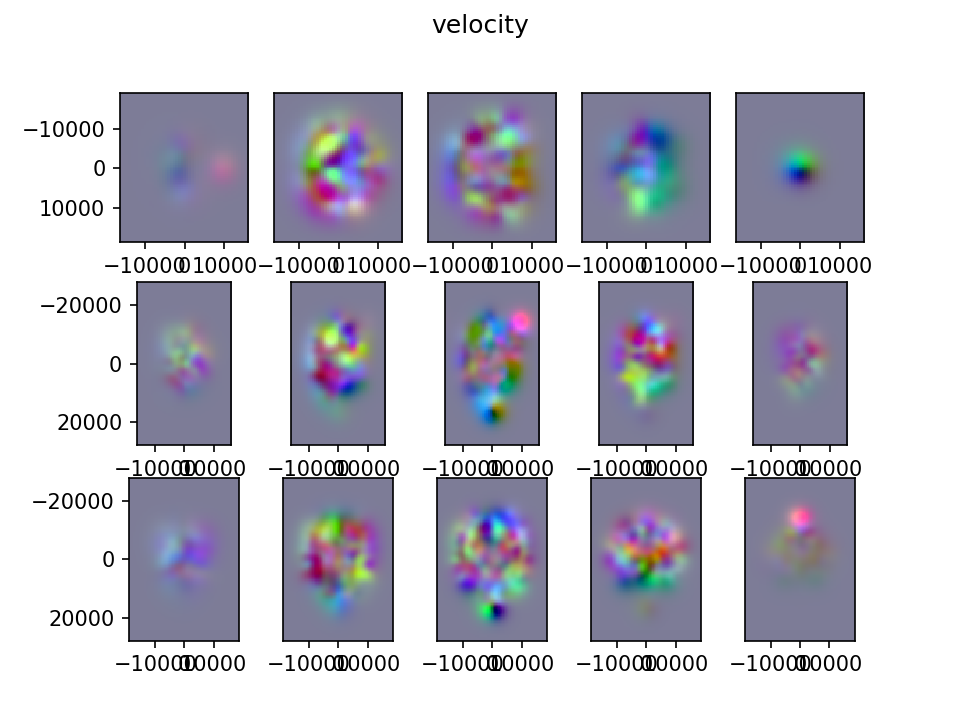

<IPython.core.display.Javascript object>


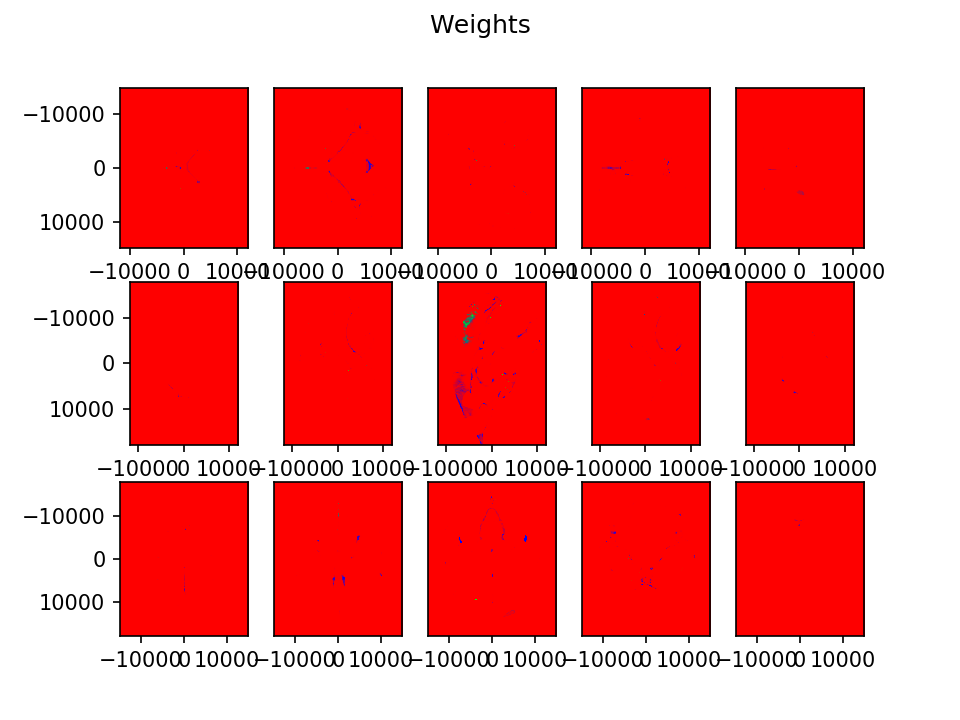

Finished iteration 0
Finished iteration 10
Finished iteration 20
Finished iteration 30
Finished iteration 40
Finished iteration 50
Finished iteration 60
Finished iteration 70
Finished iteration 80
Finished iteration 90
Finished iteration 100
Finished iteration 110
Finished iteration 120
Finished iteration 130
Finished iteration 140
Finished iteration 150
Finished iteration 160
Finished iteration 170
Finished iteration 180
Finished iteration 190


In [13]:
device = 'cuda:0'
#device = 'cpu'
output = emlddmm.emlddmm_multiscale(I=I,xI=[xI],J=J,xJ=[xJ],W0=W0,device=device,**config)

In [14]:
imp.reload(emlddmm)
emlddmm.write_transform_outputs(output_dir,output)

In [15]:
# get labels
xS,S,title,names = emlddmm.read_vtk_data(label_name,endian='l')

cpu
output dir is 1229_test_outputs/qc/


/mnt/data/csh_data/emlddmm/emlddmm.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


<IPython.core.display.Javascript object>


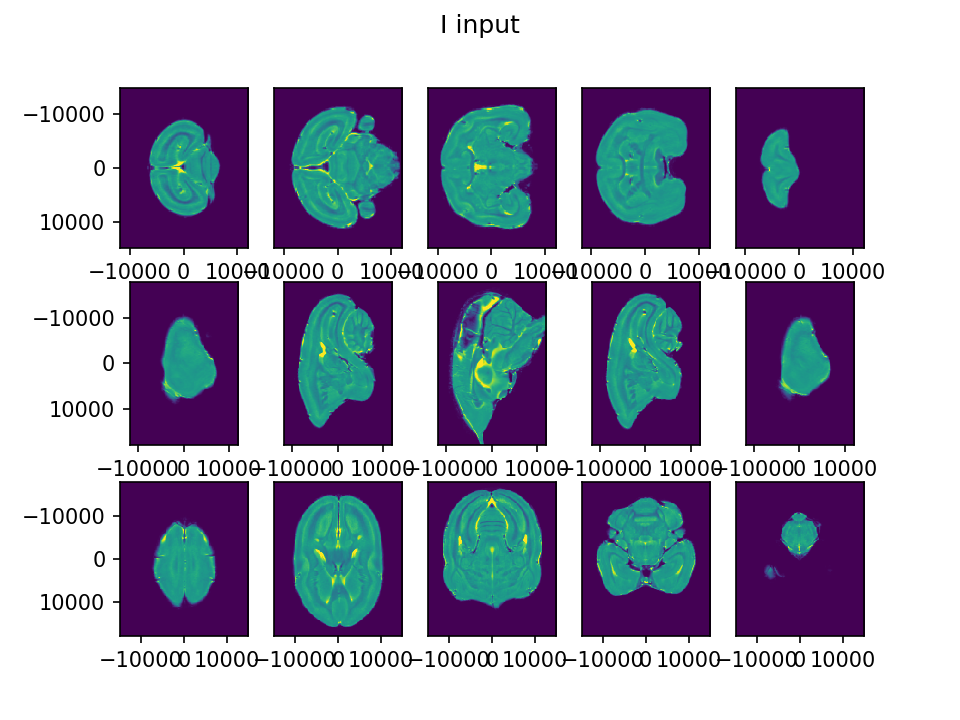

<IPython.core.display.Javascript object>


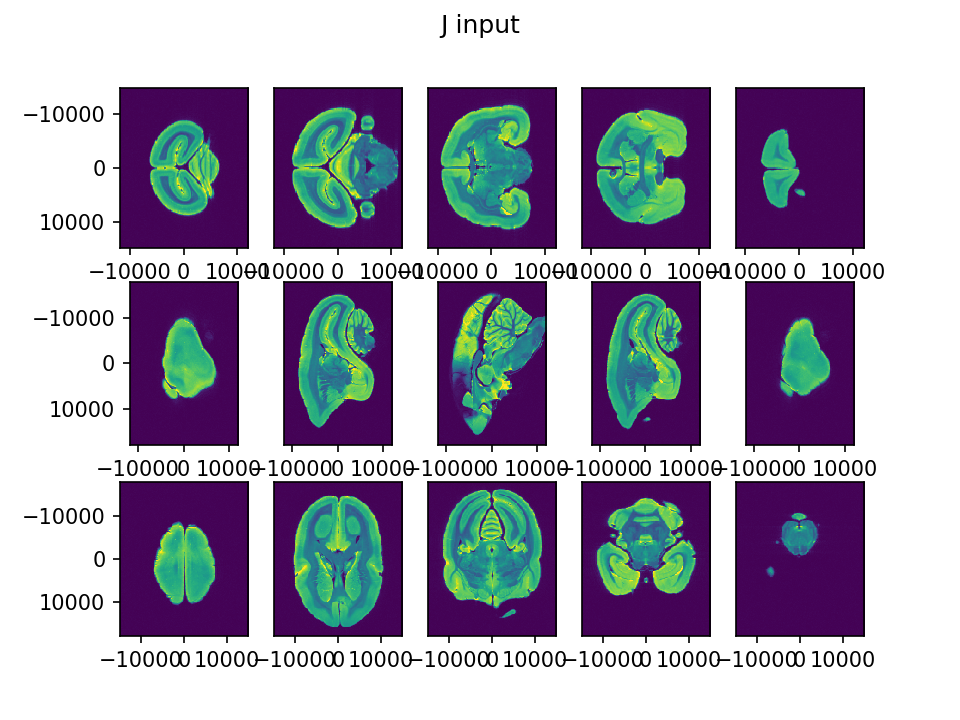

<IPython.core.display.Javascript object>


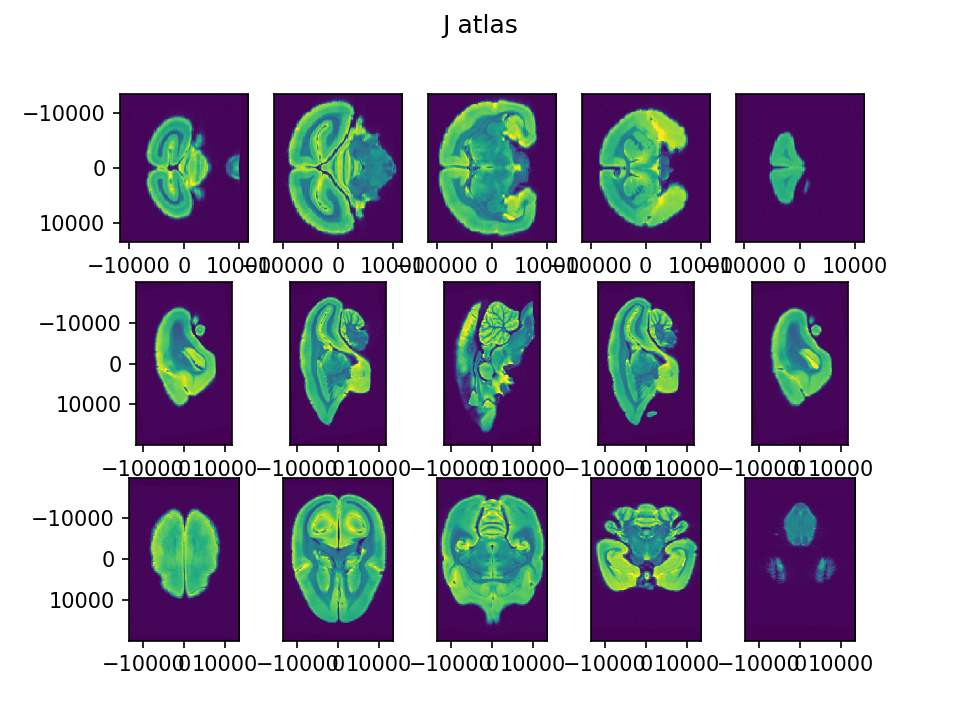

<IPython.core.display.Javascript object>


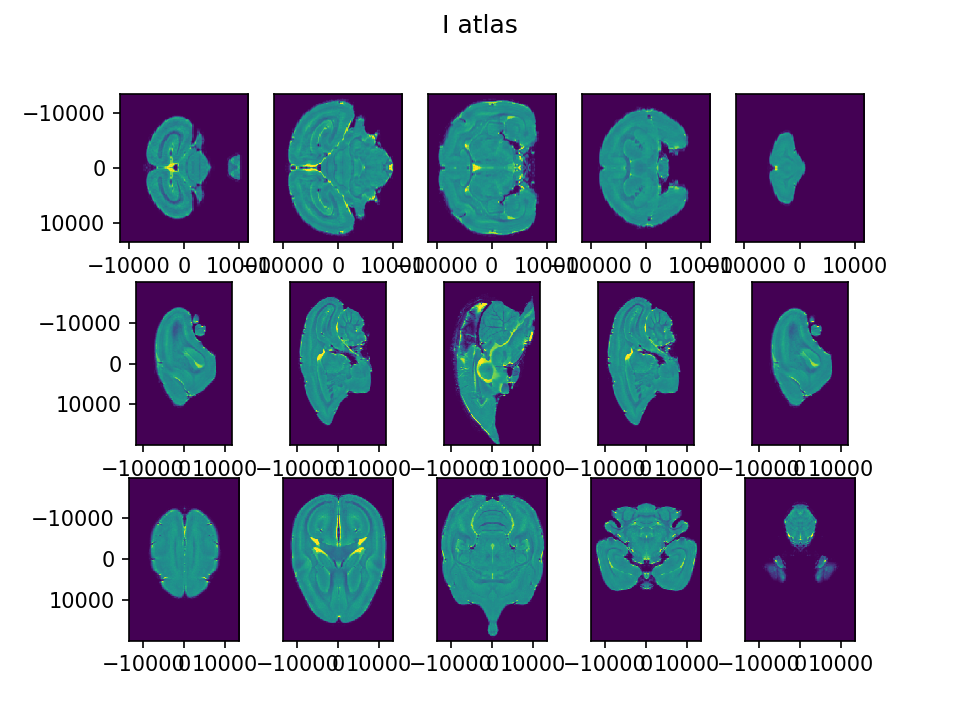

In [16]:
imp.reload(emlddmm)
emlddmm.write_qc_outputs(output_dir,output,xI,I,xJ,J,xS=xS,S=S.astype(float))

In [17]:
# test it, forward transform

imp.reload(emlddmm)
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xI]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
Jt = emlddmm.apply_transform_float(xJ,J,Xout)

<IPython.core.display.Javascript object>


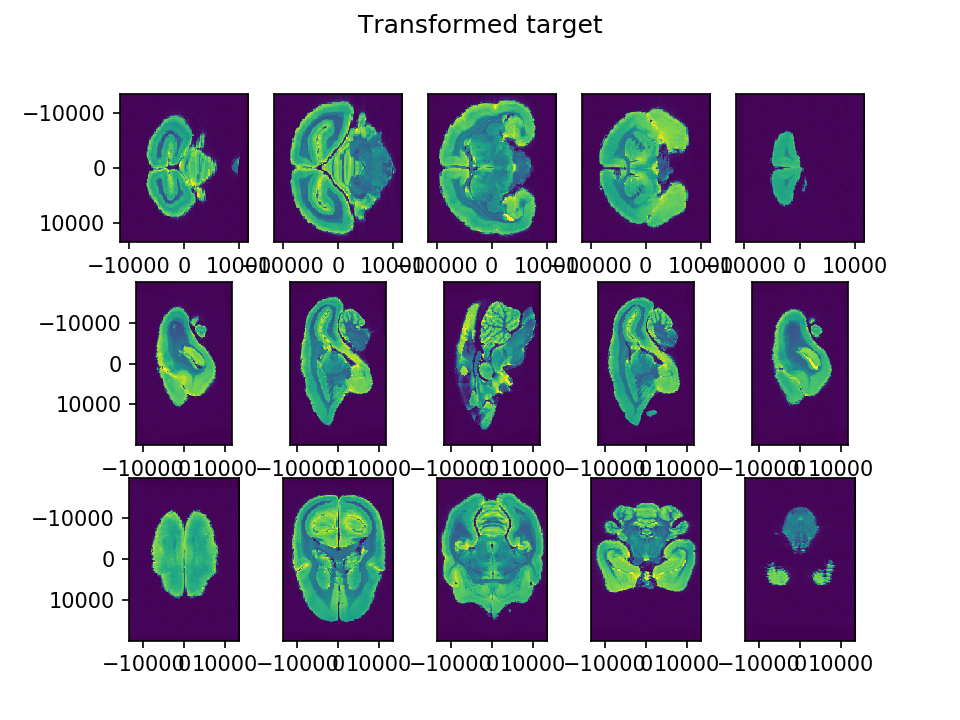

Text(0.5, 0.98, 'Transformed target')

In [18]:
import matplotlib.pyplot as plt
emlddmm.draw(Jt,xI)
plt.gcf().suptitle('Transformed target')

In [19]:
# test it, backward transform
Xin = torch.stack(torch.meshgrid([torch.as_tensor(x) for x in xJ]))
Xout = emlddmm.compose_sequence(output_dir,Xin)
It = emlddmm.apply_transform_float(xI,I,Xout)
St = emlddmm.apply_transform_int(xS,S,Xout)

<IPython.core.display.Javascript object>


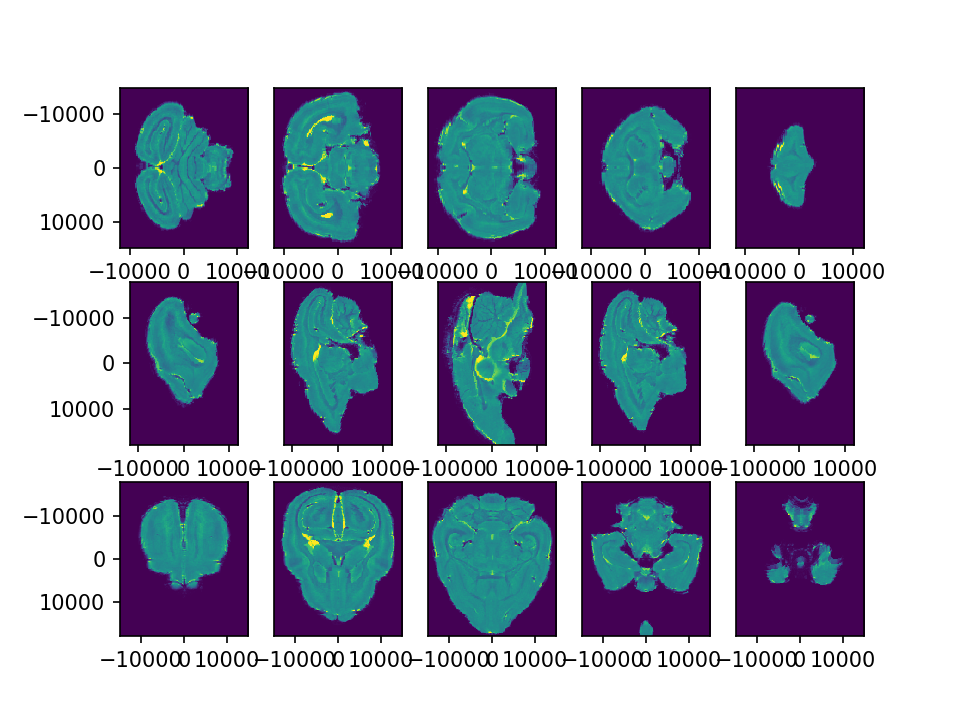

<IPython.core.display.Javascript object>


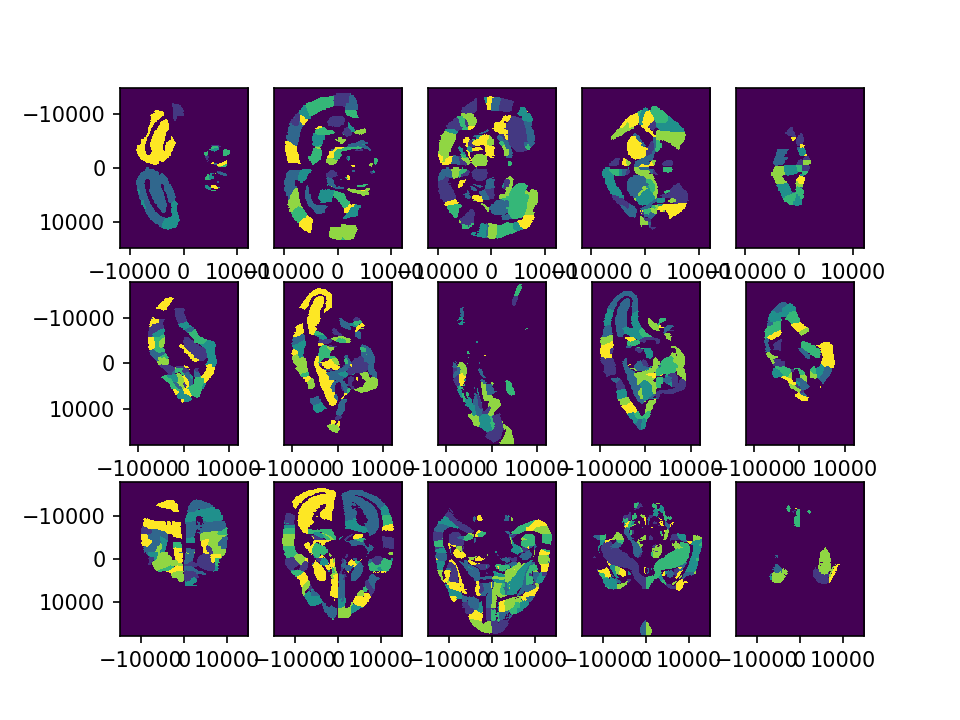

(<Figure size 640x480 with 15 Axes>,
 [[<matplotlib.axes._subplots.AxesSubplot at 0x7fe76cc91fd0>,
   <matplotlib.axes._subplots.AxesSubplot at 0x7fe76740ca90>]])

In [20]:
emlddmm.draw(It,xJ)
emlddmm.draw(St%7,xJ)

In [21]:
atlas_output_dir = os.path.join(output_dir,'to_atlas')
if not os.path.isdir(atlas_output_dir): os.mkdir(atlas_output_dir)
target_output_dir = os.path.join(output_dir,'to_target')
if not os.path.isdir(target_output_dir): os.mkdir(target_output_dir)

In [22]:
# write out
imp.reload(emlddmm)
emlddmm.write_vtk_data(os.path.join(atlas_output_dir,'target_to_atlas.vtk'),xI,Jt,'target_to_atlas')

emlddmm.write_vtk_data(os.path.join(atlas_output_dir,'atlas_to_target.vtk'),xI,It,'atlas_to_target')
emlddmm.write_vtk_data(os.path.join(atlas_output_dir,'atlas_seg_to_target.vtk'),xI,St,'atlas_seg_to_target')